<a href="https://colab.research.google.com/github/yagoojoy/PINN_Taylor-Green-Vortex/blob/main/260127_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 0. 환경 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)
torch.manual_seed(42)

# 1. 데이터 생성 클래스 (지수항 통일 및 Deterministic Noise)
class FluidGenerator:
    def __init__(self, L=4.0, nu=0.001):
        self.L, self.nu = L, nu

    # [공통] 감쇠 함수 (신호와 노이즈 비율 유지)
    def get_decay(self, t):
        k = 1
        return np.exp(-2 * (k * np.pi)**2 * self.nu * t)

    def get_tgv_solution(self, X, Y, t):
        k = 1
        decay = self.get_decay(t)
        u = -1.0 * np.cos(k * np.pi * X) * np.sin(k * np.pi * Y) * decay
        v =  1.0 * np.sin(k * np.pi * X) * np.cos(k * np.pi * Y) * decay
        p = -0.25 * (np.cos(2 * k * np.pi * X) + np.cos(2 * k * np.pi * Y)) * (decay**2)
        return u, v, p

    def get_unphysical_noise(self, X, Y, t):
        # 결정론적 노이즈 (함수 형태이므로 임의의 t에 대해 생성 가능)
        decay = self.get_decay(t)
        noise_scale = 0.1 * self.get_decay(t)
        u_n = noise_scale * np.sin(8 * np.pi * X / self.L) * np.sin(8 * np.pi * Y / self.L)
        v_n = noise_scale * np.cos(8 * np.pi * X / self.L) * np.cos(8 * np.pi * Y / self.L)
        p_n = (decay**2) * 0.1 * 0.25 * (np.sin(4 * np.pi * X / self.L))
        return u_n, v_n, p_n

    def get_data_at_t(self, nx, ny, t_val):
        x, y = np.linspace(0, self.L, nx), np.linspace(0, self.L, ny)
        X, Y = np.meshgrid(x, y)
        u_hf, v_hf, p_hf = self.get_tgv_solution(X, Y, t_val)
        u_n, v_n, p_n = self.get_unphysical_noise(X, Y, t_val)

        # LF = HF + Noise
        u_lf, v_lf, p_lf = u_hf + u_n, v_hf + v_n, p_hf + p_n

        return X, Y, u_lf, v_lf, p_lf, u_hf, v_hf, p_hf

# 2. 데이터셋 구성 (입력에 LF 포함)
L_val, nu_val, GRID = 4.0, 0.01, 100
T_max_train = 10.0
T_scale = 13.0 # 정규화 상수
generator = FluidGenerator(L=L_val, nu=nu_val)
train_times = np.linspace(0, T_max_train, 11) # 0, 1, ..., 10

# 리스트 초기화
x_list, y_list, t_list = [], [], []
u_lf_list, v_lf_list, p_lf_list = [], [], [] # [NEW] 입력으로 사용될 LF
u_hf_list, v_hf_list, p_hf_list = [], [], [] # [NEW] 타겟으로 사용될 HF

print("Generating Data: Inputs (x,y,t, LF) -> Targets (HF)...")
for t in train_times:
    X, Y, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, t)

    x_list.append(X.flatten())
    y_list.append(Y.flatten())
    t_list.append(np.full(X.size, t))

    # LF를 입력(Feature)으로 저장
    u_lf_list.append(u_l.flatten())
    v_lf_list.append(v_l.flatten())
    p_lf_list.append(p_l.flatten())

    # HF를 정답(Target)으로 저장
    u_hf_list.append(u_h.flatten())
    v_hf_list.append(v_h.flatten())
    p_hf_list.append(p_h.flatten())

# 텐서 변환
# 1. 좌표 입력
x_train = torch.tensor(np.concatenate(x_list)/L_val, dtype=torch.float32).view(-1, 1).to(device)
y_train = torch.tensor(np.concatenate(y_list)/L_val, dtype=torch.float32).view(-1, 1).to(device)
t_train = torch.tensor(np.concatenate(t_list)/T_scale, dtype=torch.float32).view(-1, 1).to(device)

# 2. LF 유동장 입력 (Input Features)
u_lf_train = torch.tensor(np.concatenate(u_lf_list), dtype=torch.float32).view(-1, 1).to(device)
v_lf_train = torch.tensor(np.concatenate(v_lf_list), dtype=torch.float32).view(-1, 1).to(device)
p_lf_train = torch.tensor(np.concatenate(p_lf_list), dtype=torch.float32).view(-1, 1).to(device)

# 3. HF 유동장 타겟 (Labels)
u_hf_train = torch.tensor(np.concatenate(u_hf_list), dtype=torch.float32).view(-1, 1).to(device)
v_hf_train = torch.tensor(np.concatenate(v_hf_list), dtype=torch.float32).view(-1, 1).to(device)
p_hf_train = torch.tensor(np.concatenate(p_hf_list), dtype=torch.float32).view(-1, 1).to(device)

# 3. 모델 정의 (입력 차원 증가: 3 -> 6)
class FourierEmbedding(nn.Module):
    def __init__(self, in_channels, scale=4.0):
        super().__init__()
        # 좌표(x,y,t)에 대해서만 Fourier Feature를 적용하는 것이 일반적이나,
        # 여기서는 전체 입력 6개에 대해 적용하거나, 좌표만 적용 후 LF는 concat할 수 있습니다.
        # 간단하고 강력한 성능을 위해 6개 채널 모두 임베딩하거나,
        # 좌표 3개만 임베딩하고 나머지는 그냥 붙이는 방식을 씁니다.
        # 여기서는 "좌표(3) 임베딩 + LF(3) 원본" 구조를 추천합니다. (물리적 위치 정보 강조)
        self.register_buffer("B", torch.randn(3, 128) * scale) # 좌표용 B

    def forward(self, coords, fields):
        # coords: x, y, t
        # fields: u_lf, v_lf, p_lf
        x_proj = 2 * np.pi * coords @ self.B
        emb = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        # 임베딩된 좌표 특징과 원본 LF 값을 결합
        return torch.cat([emb, fields], dim=-1)

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = FourierEmbedding(in_channels=3) # 좌표 3개 임베딩
        # 입력 크기: (128*2) + 3(LF fields) = 259
        self.net = nn.Sequential(
            nn.Linear(256 + 3, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 3) # Output: HF correction
        )
    def forward(self, x, y, t, u_lf, v_lf, p_lf):
        coords = torch.cat([x, y, t], dim=1)
        fields = torch.cat([u_lf, v_lf, p_lf], dim=1)
        return self.net(self.embedding(coords, fields))

# 4. Phase 0: Warm-up (Supervised Learning: LF input -> HF output)
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("\n--- Phase 0: Warm-up (Learning to map LF to HF) ---")
for epoch in range(1501):
    optimizer.zero_grad()
    # 입력으로 LF 데이터도 함께 줍니다.
    pred = model(x_train, y_train, t_train, u_lf_train, v_lf_train, p_lf_train)

    # 타겟은 HF 데이터입니다.
    loss = torch.mean((pred[:,0:1]-u_hf_train)**2 + \
                      (pred[:,1:2]-v_hf_train)**2 + \
                      (pred[:,2:3]-p_hf_train)**2)

    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
      print(f"Epoch {epoch} | Loss: {loss.item():.6f}")
    if loss.item() < 0.0005:
      print(f"Epoch {epoch} | Loss: {loss.item():.6f}")
      break

torch.save(model.state_dict(), "warmup_model.pth")

Generating Data: Inputs (x,y,t, LF) -> Targets (HF)...

--- Phase 0: Warm-up (Learning to map LF to HF) ---
Epoch 0 | Loss: 0.158489
Epoch 50 | Loss: 0.023897
Epoch 100 | Loss: 0.009290
Epoch 150 | Loss: 0.001531
Epoch 200 | Loss: 0.000567
Epoch 210 | Loss: 0.000496



--- Phase 1: Physics Training with Focused Sampling ---
Ep     0 | Total: 0.000367 | Data: 0.000489 | PDE: 0.541632
         > Last 500 eps: 0.54s | Total: 0.0m
Ep   500 | Total: 0.002036 | Data: 0.000463 | PDE: 0.010135
         > Last 500 eps: 395.54s | Total: 6.6m
Ep  1000 | Total: 0.000894 | Data: 0.000268 | PDE: 0.002079
         > Last 500 eps: 395.29s | Total: 13.2m
Ep  1500 | Total: 0.000564 | Data: 0.000231 | PDE: 0.000781
         > Last 500 eps: 395.68s | Total: 19.8m
Ep  2000 | Total: 0.000432 | Data: 0.000223 | PDE: 0.000396
         > Last 500 eps: 395.47s | Total: 26.4m
Ep  2500 | Total: 0.000364 | Data: 0.000223 | PDE: 0.000236
         > Last 500 eps: 395.69s | Total: 33.0m
Ep  3000 | Total: 0.000327 | Data: 0.000224 | PDE: 0.000159
         > Last 500 eps: 395.44s | Total: 39.6m

--- Phase 2: Refinement (L-BFGS) ---
L-BFGS Complete. Duration: 1632.71 sec

[Interpolation (t=1.25)] Time t=1.25
Input MSE (LF vs HF): 0.00233227
Output MSE (Pred vs HF): 0.00012186
Improve

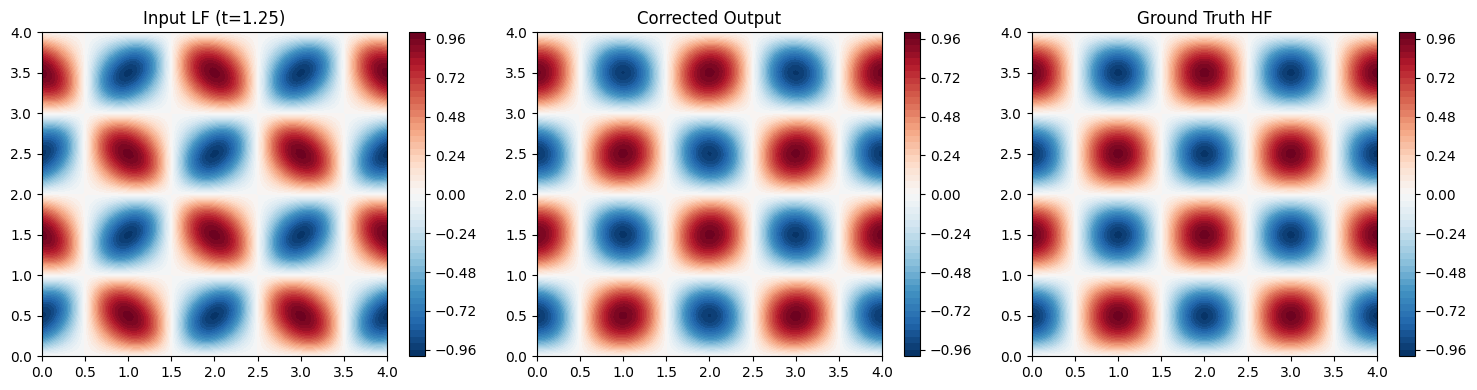


[Extrapolation (t=2.5)] Time t=2.5
Input MSE (LF vs HF): 0.00221997
Output MSE (Pred vs HF): 0.00012607
Improvement: 94.32%


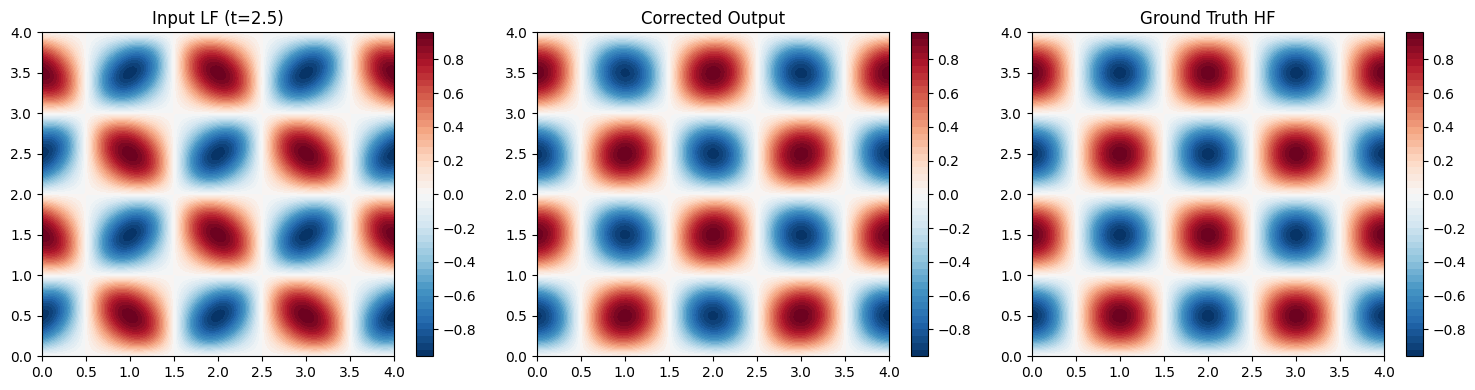


[Extrapolation (t=7.3)] Time t=7.3
Input MSE (LF vs HF): 0.00183675
Output MSE (Pred vs HF): 0.00005796
Improvement: 96.84%


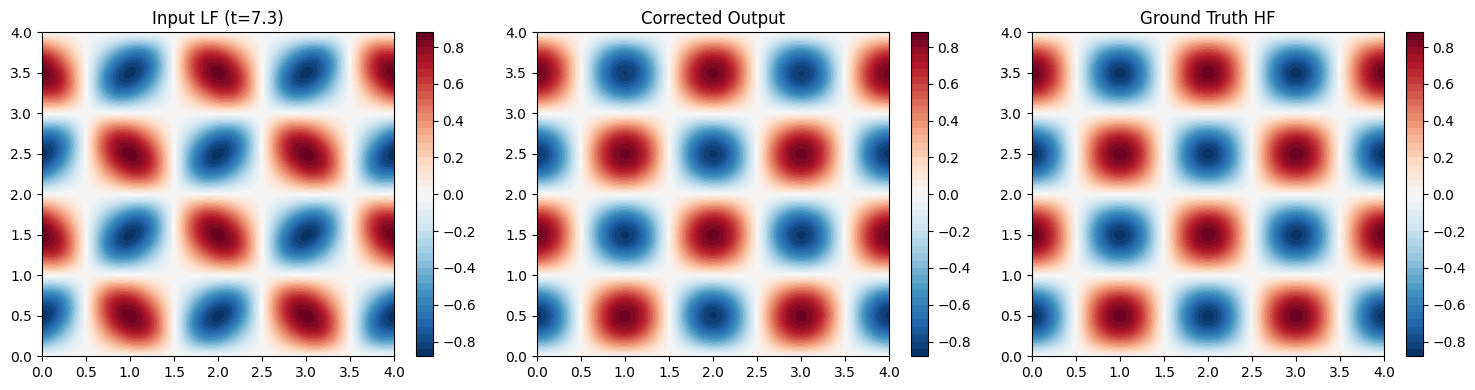


[Extrapolation (t=10.0)] Time t=10.0
Input MSE (LF vs HF): 0.00165104
Output MSE (Pred vs HF): 0.00004617
Improvement: 97.20%


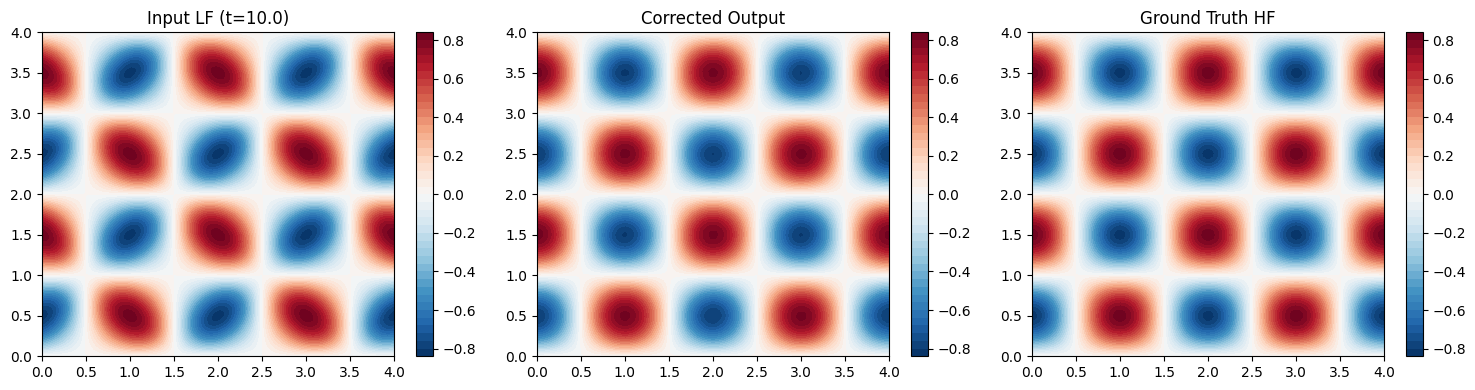


[Extrapolation (t=11.5)] Time t=11.5
Input MSE (LF vs HF): 0.00155611
Output MSE (Pred vs HF): 0.00006095
Improvement: 96.08%


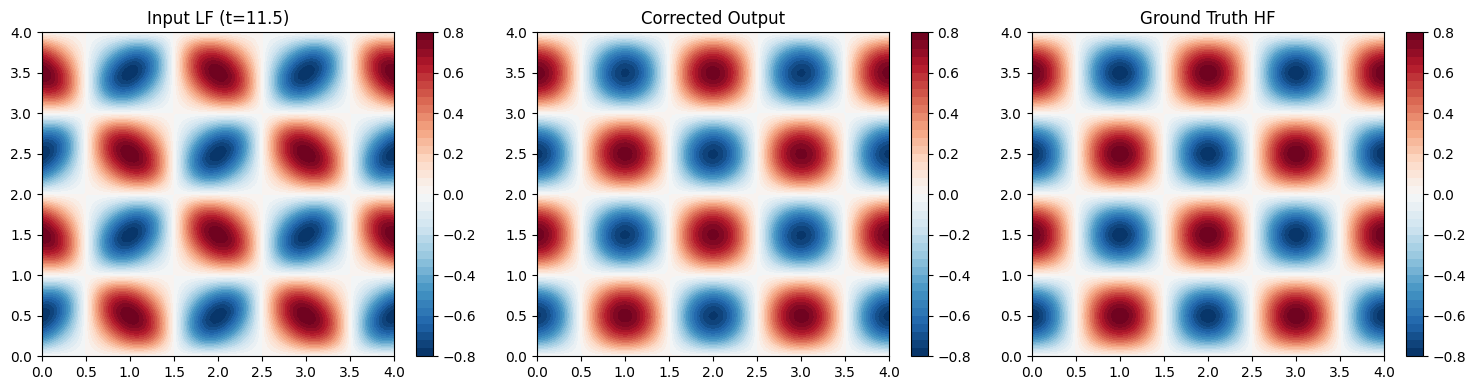


[Extrapolation (t=13.0)] Time t=13.0
Input MSE (LF vs HF): 0.00146663
Output MSE (Pred vs HF): 0.00007877
Improvement: 94.63%


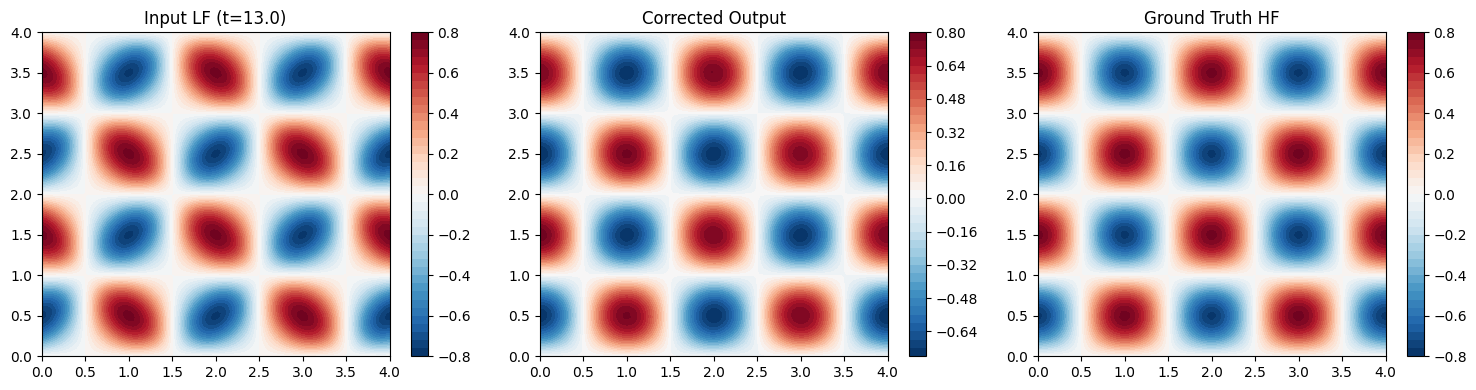


[Extrapolation (t=15.0)] Time t=15.0
Input MSE (LF vs HF): 0.00135529
Output MSE (Pred vs HF): 0.00013534
Improvement: 90.01%


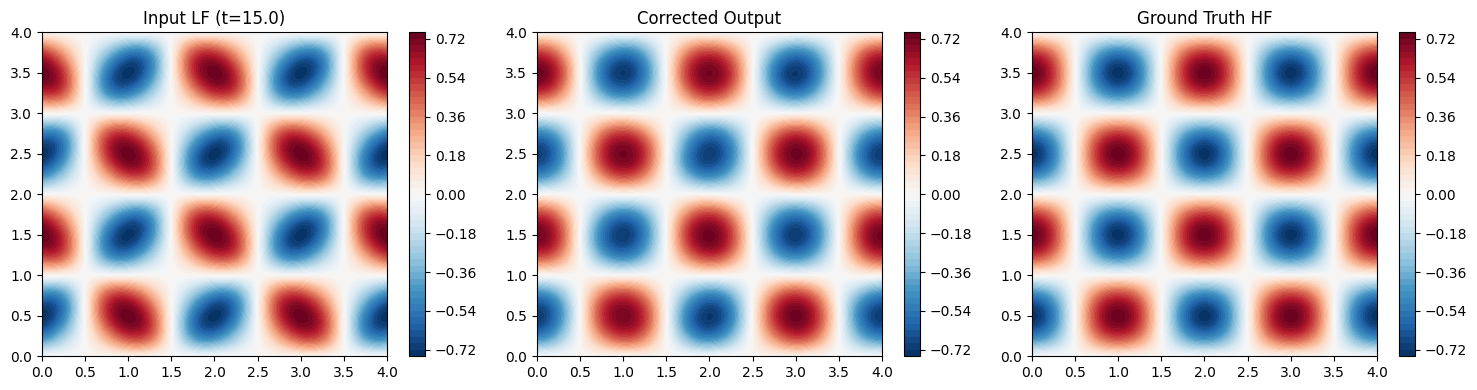


[Extrapolation (t=20.0)] Time t=20.0
Input MSE (LF vs HF): 0.00111251
Output MSE (Pred vs HF): 0.00015594
Improvement: 85.98%


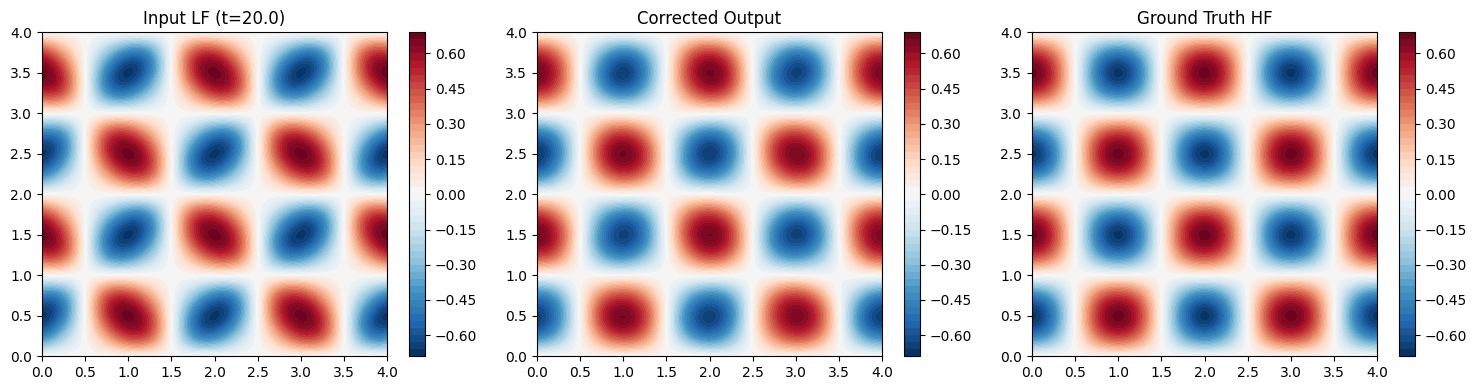


[Extrapolation (t=25.0)] Time t=25.0
Input MSE (LF vs HF): 0.00091323
Output MSE (Pred vs HF): 0.00017789
Improvement: 80.52%


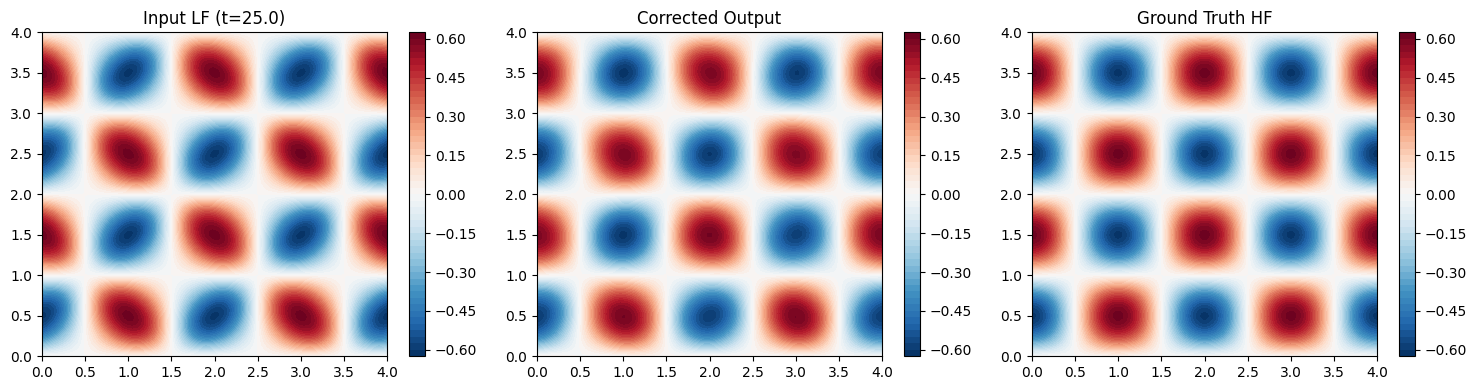


[Extrapolation (t=30.0)] Time t=30.0
Input MSE (LF vs HF): 0.00074964
Output MSE (Pred vs HF): 0.00018144
Improvement: 75.80%


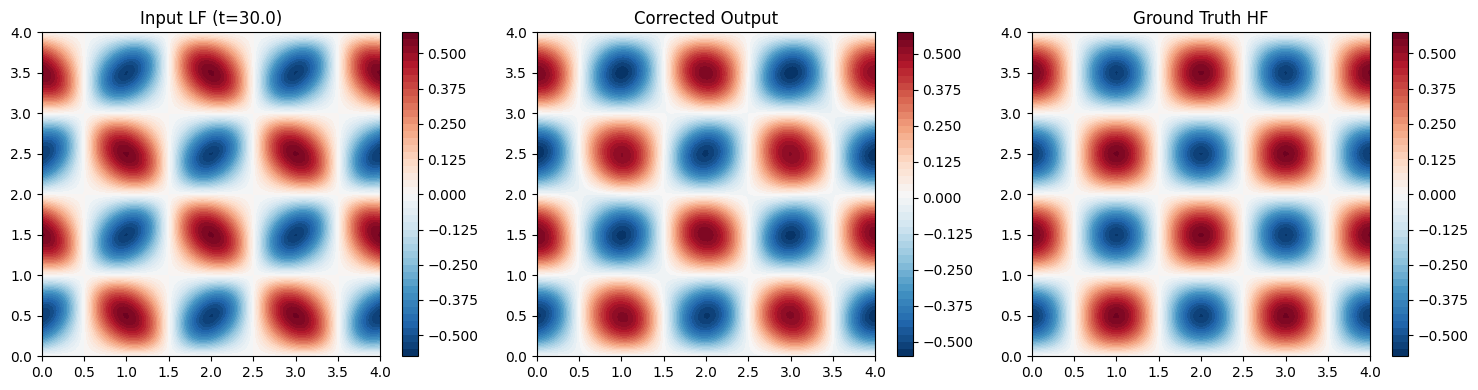

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

def clear_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# 파라미터 유지
L_val = 4.0
nu_val = 0.001
T_scale = 13.0
T_pred_max = 13.0
T_train_max = 10.0 # 학습 데이터의 한계 시점

generator = FluidGenerator(L=L_val, nu=nu_val)

# 1. 물리 식 정의 (동일)
def get_pde_loss(model, x, y, t, u_lf_in, v_lf_in, p_lf_in, nu, L, T_scale):
    out = model(x, y, t, u_lf_in, v_lf_in, p_lf_in)
    u, v, p = out[:, 0:1], out[:, 1:2], out[:, 2:3]

    def grad(outputs, inputs):
        return torch.autograd.grad(outputs, inputs, torch.ones_like(outputs), create_graph=True)[0]

    u_t = grad(u, t) / T_scale
    v_t = grad(v, t) / T_scale
    u_x_raw, u_y_raw = grad(u, x), grad(u, y)
    v_x_raw, v_y_raw = grad(v, x), grad(v, y)
    p_x_raw, p_y_raw = grad(p, x), grad(p, y)

    u_x, u_y = u_x_raw/L, u_y_raw/L
    v_x, v_y = v_x_raw/L, v_y_raw/L
    p_x, p_y = p_x_raw/L, p_y_raw/L

    u_xx, u_yy = grad(u_x_raw, x)/(L**2), grad(u_y_raw, y)/(L**2)
    v_xx, v_yy = grad(v_x_raw, x)/(L**2), grad(v_y_raw, y)/(L**2)

    f_mass = u_x + v_y
    f_u = u_t + (u*u_x + v*u_y) + p_x - nu*(u_xx + u_yy)
    f_v = v_t + (u*v_x + v*v_y) + p_y - nu*(v_xx + v_yy)

    return torch.mean(f_mass**2), torch.mean(f_u**2 + f_v**2)

# 2. 학습 준비
clear_memory()
model = PINN().to(device)
model.load_state_dict(torch.load("warmup_model.pth"))

# PDE용 그리드 설정 (기본 틀)
nt_p, nx_p, ny_p = 30, 40, 40 # 샘플 개수 살짝 조정
t_g = torch.linspace(0, T_pred_max/T_scale, nt_p, device=device)
x_g = torch.linspace(0, 1, nx_p, device=device)
y_g = torch.linspace(0, 1, ny_p, device=device)
# 메쉬그리드는 shape 참조용으로만 사용
T_m, X_m, Y_m = torch.meshgrid(t_g, x_g, y_g, indexing='ij')

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# ==========================================
# 3. Phase 1: Physics Training (Focus Sampling)
# ==========================================
print("\n--- Phase 1: Physics Training with Focused Sampling ---")

phase1_start_time = time.time()
block_start_time = time.time()

# [전략] 배치의 절반은 0~10초(학습영역), 절반은 10~13초(외삽영역)에서 샘플링
half_size = T_m.numel() // 2

for epoch in range(3001):
    if epoch == 3000:
        for pg in optimizer.param_groups: pg['lr'] = 5e-5

    optimizer.zero_grad()

    # --- [수정된 샘플링 로직 시작] ---
    # 1. 학습 구간 (0 ~ 10초) 샘플링
    t_1 = torch.rand(half_size, 1, device=device) * (T_train_max / T_scale)

    # 2. 외삽 구간 (10 ~ 13초) 샘플링 -> 모델에게 "여기를 잘 봐!"라고 강제
    t_2 = torch.rand(half_size, 1, device=device) * ((T_pred_max - T_train_max) / T_scale) + (T_train_max / T_scale)

    # 3. 합치기
    t_rand = torch.cat([t_1, t_2], dim=0)

    # x, y는 전체 구간(0~1)에서 랜덤
    x_rand = torch.rand(half_size * 2, 1, device=device)
    y_rand = torch.rand(half_size * 2, 1, device=device)

    # 실제 물리 좌표로 변환 (LF 생성용)
    x_phys_np = x_rand.cpu().numpy() * L_val
    y_phys_np = y_rand.cpu().numpy() * L_val
    t_phys_np = t_rand.cpu().numpy() * T_scale

    # LF 값 생성
    u_h_np, v_h_np, p_h_np = generator.get_tgv_solution(x_phys_np, y_phys_np, t_phys_np)
    u_n_np, v_n_np, p_n_np = generator.get_unphysical_noise(x_phys_np, y_phys_np, t_phys_np)

    u_lf_in = torch.tensor(u_h_np + u_n_np, dtype=torch.float32).to(device)
    v_lf_in = torch.tensor(v_h_np + v_n_np, dtype=torch.float32).to(device)
    p_lf_in = torch.tensor(p_h_np + p_n_np, dtype=torch.float32).to(device)

    # Gradient 추적 설정
    x_p = x_rand.requires_grad_(True)
    y_p = y_rand.requires_grad_(True)
    t_p = t_rand.requires_grad_(True)
    # --- [수정된 샘플링 로직 끝] ---

    # 1. Data Loss
    pred_data = model(x_train, y_train, t_train, u_lf_train, v_lf_train, p_lf_train)
    l_data = torch.mean((pred_data[:,0:1]-u_hf_train)**2 + \
                        (pred_data[:,1:2]-v_hf_train)**2 + \
                        (pred_data[:,2:3]-p_hf_train)**2)

    # 2. PDE Loss (집중 샘플링된 점들)
    l_mass, l_mom = get_pde_loss(model, x_p, y_p, t_p, u_lf_in, v_lf_in, p_lf_in, nu_val, L_val, T_scale)

    pde_w = min(1.0 * (epoch/3000), 1.0)
    total_loss = 0.75 * l_data + pde_w * (l_mass + l_mom)

    total_loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        current_time = time.time()
        block_duration = current_time - block_start_time
        total_elapsed = current_time - phase1_start_time
        print(f"Ep {epoch:5d} | Total: {total_loss.item():.6f} | Data: {l_data.item():.6f} | PDE: {l_mass.item()+l_mom.item():.6f}")
        print(f"         > Last 500 eps: {block_duration:.2f}s | Total: {total_elapsed/60:.1f}m")
        block_start_time = time.time()

# ==========================================
# 4. Phase 2: L-BFGS
# ==========================================
print("\n--- Phase 2: Refinement (L-BFGS) ---")
lbfgs = optim.LBFGS(model.parameters(), max_iter=2000, history_size=50, line_search_fn="strong_wolfe")

def closure():
    lbfgs.zero_grad()
    out = model(x_train, y_train, t_train, u_lf_train, v_lf_train, p_lf_train)
    ld = torch.mean((out[:,0:1]-u_hf_train)**2 + (out[:,1:2]-v_hf_train)**2 + (out[:,2:3]-p_hf_train)**2)
    lm, lmo = get_pde_loss(model, x_p, y_p, t_p, u_lf_in, v_lf_in, p_lf_in, nu_val, L_val, T_scale)
    loss = 0.75 * ld + 1.0 * (lm + lmo) # PDE 가중치 1.0 유지
    if loss.requires_grad: loss.backward()
    return loss

lbfgs_start_time = time.time()
lbfgs.step(closure)
lbfgs_end_time = time.time()
print(f"L-BFGS Complete. Duration: {lbfgs_end_time - lbfgs_start_time:.2f} sec")

# ==========================================
# 5. 결과 검증
# ==========================================
def test_correction(test_t, scenario_name):
    X_g, Y_g, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, test_t)

    x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
    y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
    t_in = torch.tensor(np.full(x_in.shape, test_t/T_scale), dtype=torch.float32).view(-1, 1).to(device)

    u_lf_in = torch.tensor(u_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    v_lf_in = torch.tensor(v_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    p_lf_in = torch.tensor(p_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)

    model.eval()
    with torch.no_grad():
        out = model(x_in, y_in, t_in, u_lf_in, v_lf_in, p_lf_in)
        u_pred = out[:, 0].cpu().numpy().reshape(GRID, GRID)

    mse_lf = np.mean((u_l - u_h)**2)
    mse_pinn = np.mean((u_pred - u_h)**2)

    print(f"\n[{scenario_name}] Time t={test_t}")
    print(f"Input MSE (LF vs HF): {mse_lf:.8f}")
    print(f"Output MSE (Pred vs HF): {mse_pinn:.8f}")
    if mse_lf > 1e-12:
        print(f"Improvement: {(mse_lf - mse_pinn)/mse_lf * 100:.2f}%")
    else:
        print("Improvement: N/A")

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1); plt.title(f"Input LF (t={test_t})"); plt.contourf(X_g, Y_g, u_l, 50, cmap='RdBu_r'); plt.colorbar()
    plt.subplot(1, 3, 2); plt.title("Corrected Output"); plt.contourf(X_g, Y_g, u_pred, 50, cmap='RdBu_r'); plt.colorbar()
    plt.subplot(1, 3, 3); plt.title("Ground Truth HF"); plt.contourf(X_g, Y_g, u_h, 50, cmap='RdBu_r'); plt.colorbar()
    plt.tight_layout(); plt.show()

test_correction(1.25, "Interpolation (t=1.25)")
test_correction(2.5, "Extrapolation (t=2.5)")
test_correction(7.3, "Extrapolation (t=7.3)")
test_correction(10.0, "Extrapolation (t=10.0)")
test_correction(11.5, "Extrapolation (t=11.5)")
test_correction(13.0, "Extrapolation (t=13.0)")
test_correction(15.0, "Extrapolation (t=15.0)")
test_correction(20.0, "Extrapolation (t=20.0)")
test_correction(25.0, "Extrapolation (t=25.0)")
test_correction(30.0, "Extrapolation (t=30.0)")


[Interpolation (t=1.25)] Time t=1.25
Input MSE (LF vs HF): 0.00233227
Output MSE (Pred vs HF): 0.00012186
Improvement: 94.78%


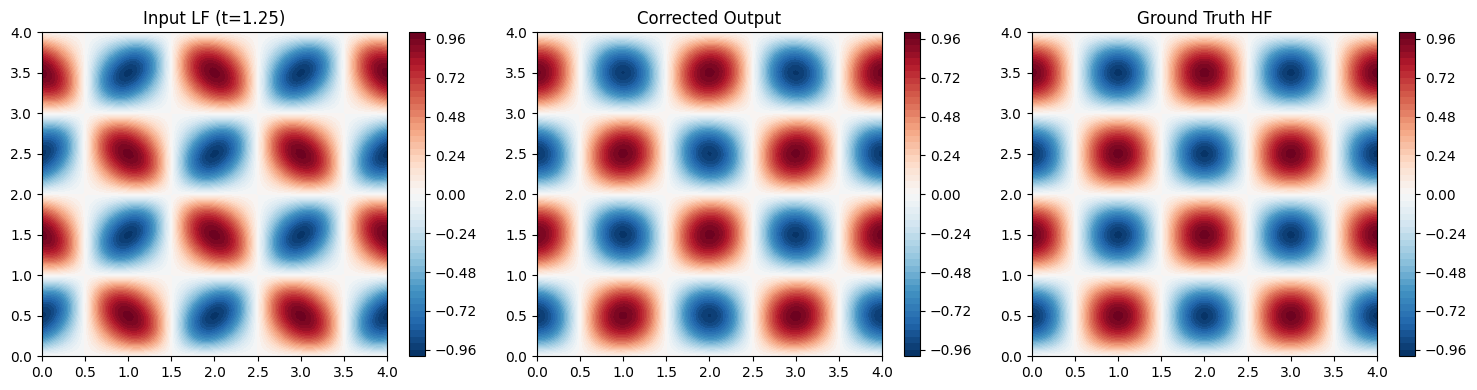


[Extrapolation (t=2.5)] Time t=2.5
Input MSE (LF vs HF): 0.00221997
Output MSE (Pred vs HF): 0.00012607
Improvement: 94.32%


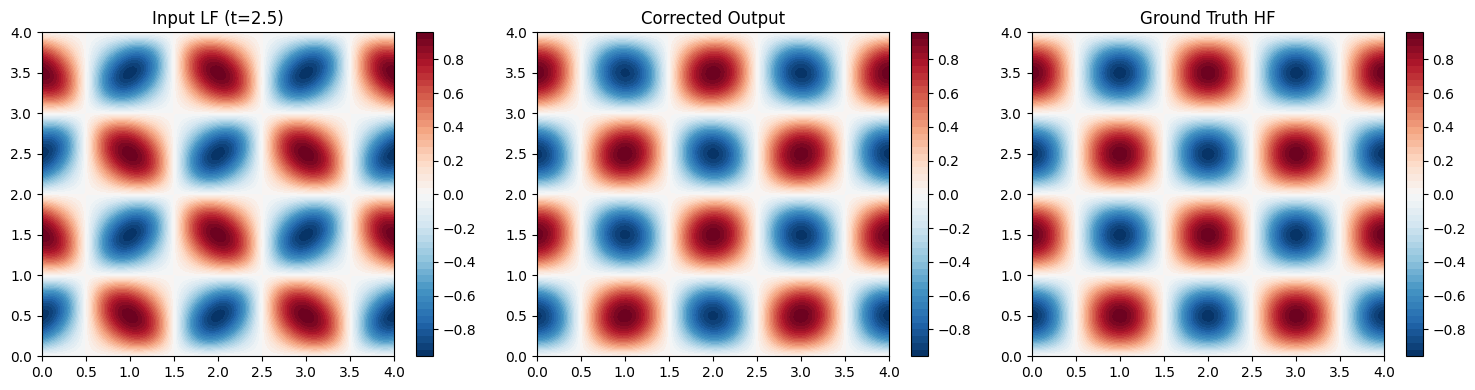


[Extrapolation (t=7.3)] Time t=7.3
Input MSE (LF vs HF): 0.00183675
Output MSE (Pred vs HF): 0.00005796
Improvement: 96.84%


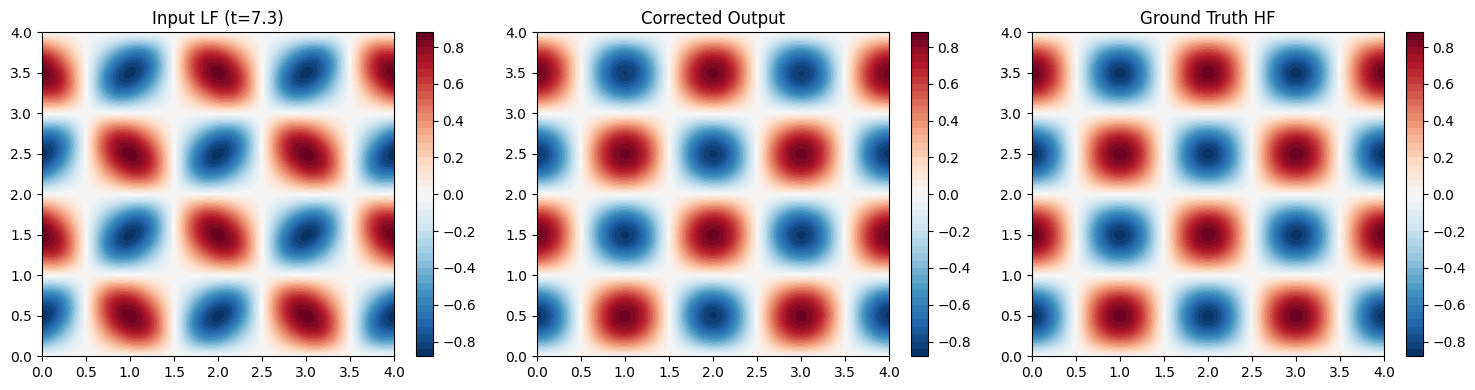


[Extrapolation (t=9.5)] Time t=9.5
Input MSE (LF vs HF): 0.00168395
Output MSE (Pred vs HF): 0.00004658
Improvement: 97.23%


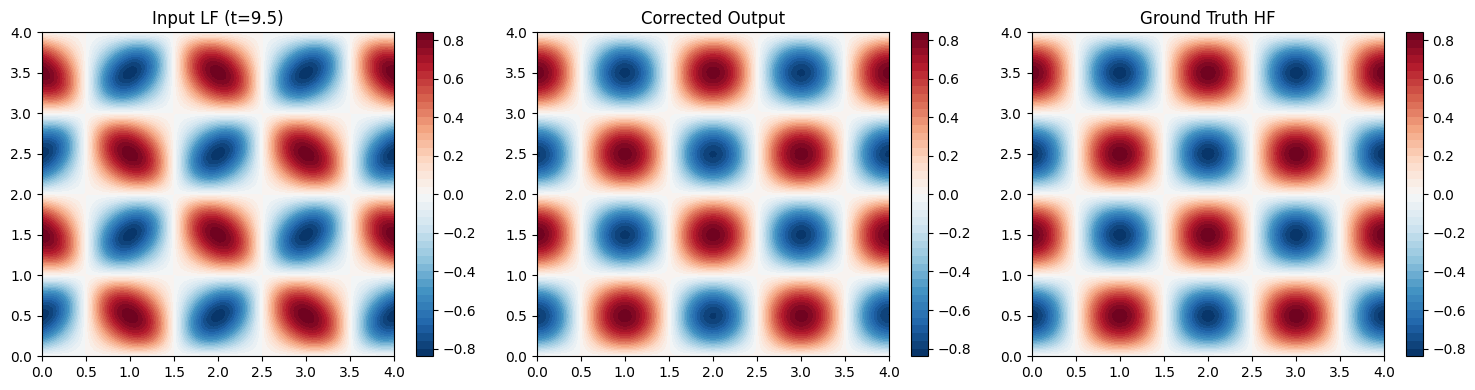


[Extrapolation (t=11.5)] Time t=11.5
Input MSE (LF vs HF): 0.00155611
Output MSE (Pred vs HF): 0.00006095
Improvement: 96.08%


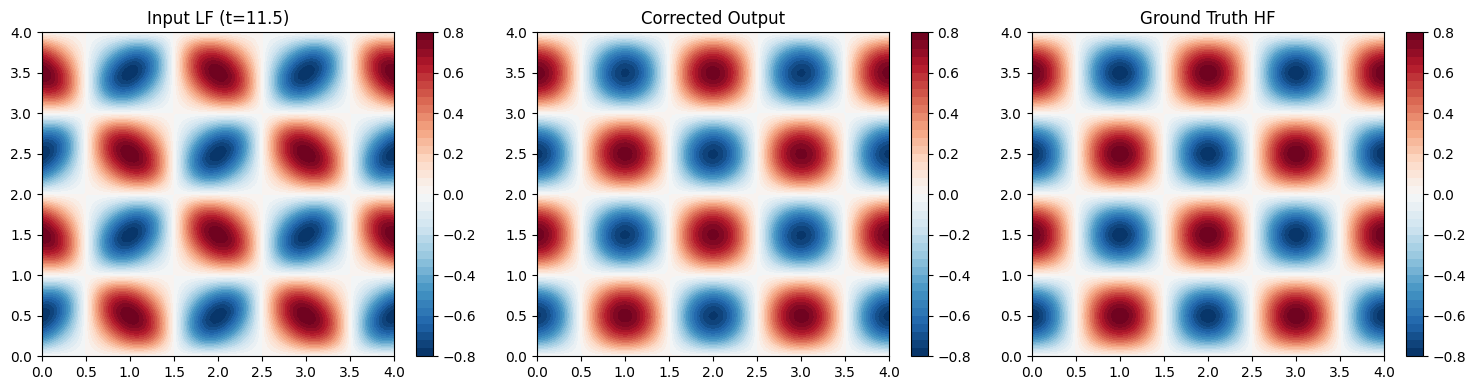


[Extrapolation (t=13.0)] Time t=13.0
Input MSE (LF vs HF): 0.00146663
Output MSE (Pred vs HF): 0.00007877
Improvement: 94.63%


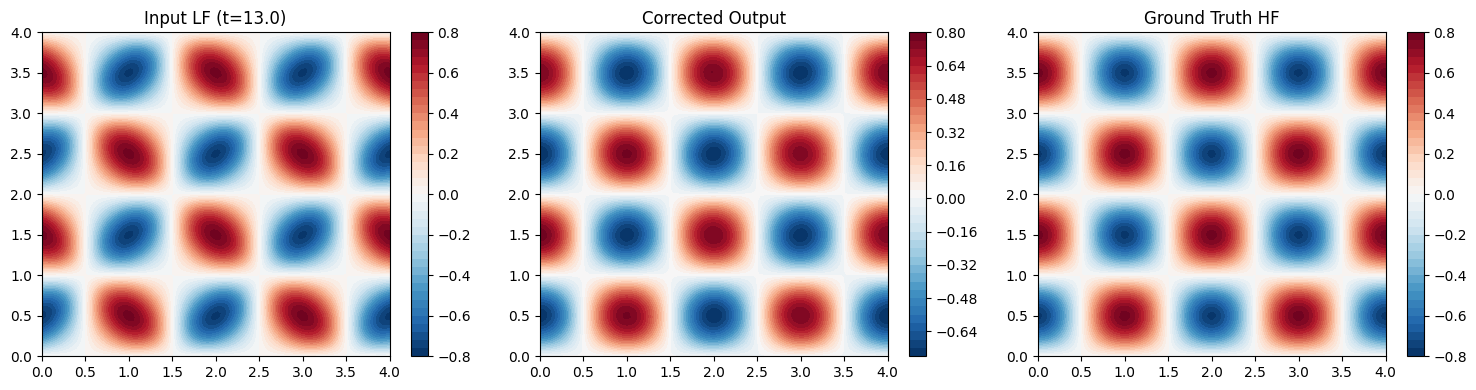


[Extrapolation (t=15.0)] Time t=15.0
Input MSE (LF vs HF): 0.00135529
Output MSE (Pred vs HF): 0.00013534
Improvement: 90.01%


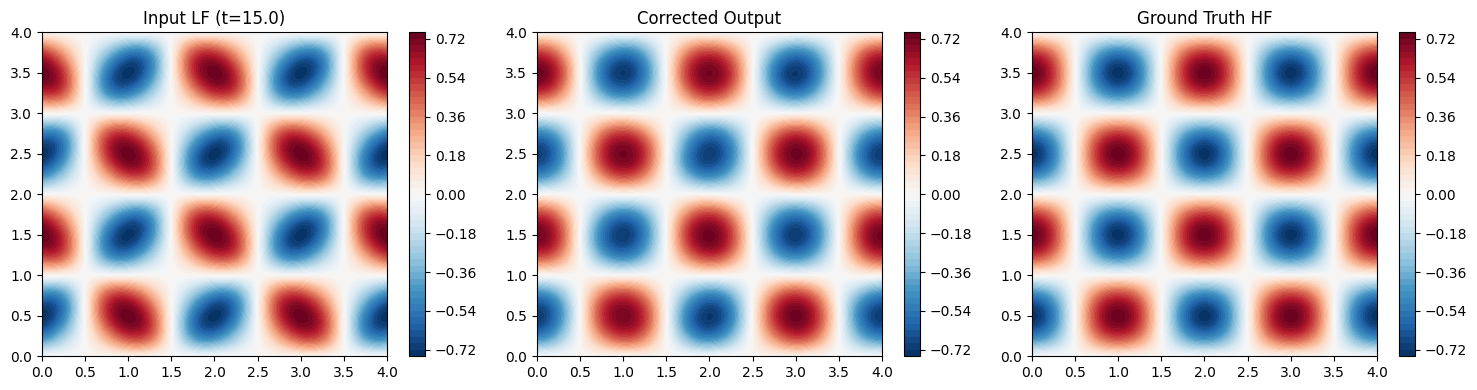


[Extrapolation (t=20.0)] Time t=20.0
Input MSE (LF vs HF): 0.00111251
Output MSE (Pred vs HF): 0.00015594
Improvement: 85.98%


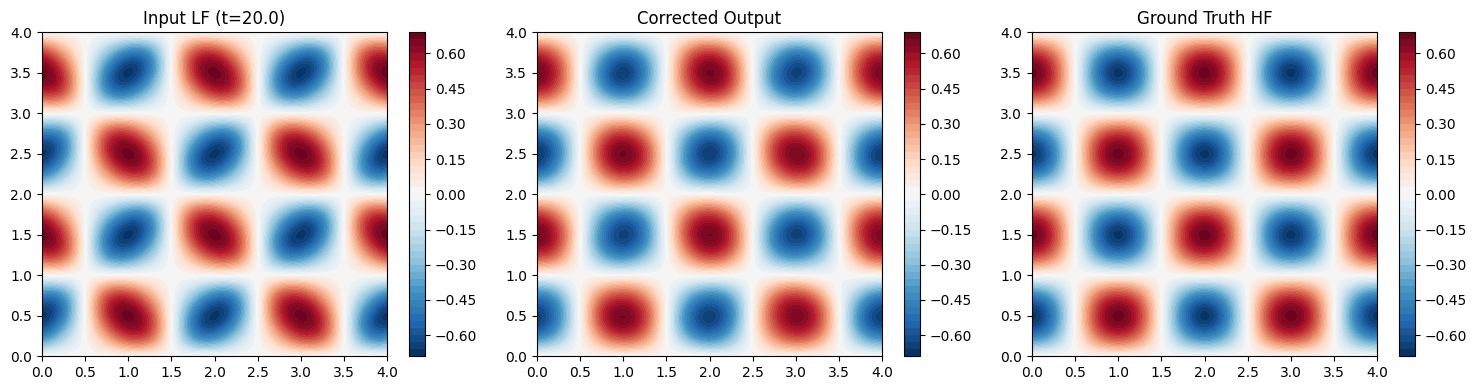


[Extrapolation (t=25.0)] Time t=25.0
Input MSE (LF vs HF): 0.00091323
Output MSE (Pred vs HF): 0.00017789
Improvement: 80.52%


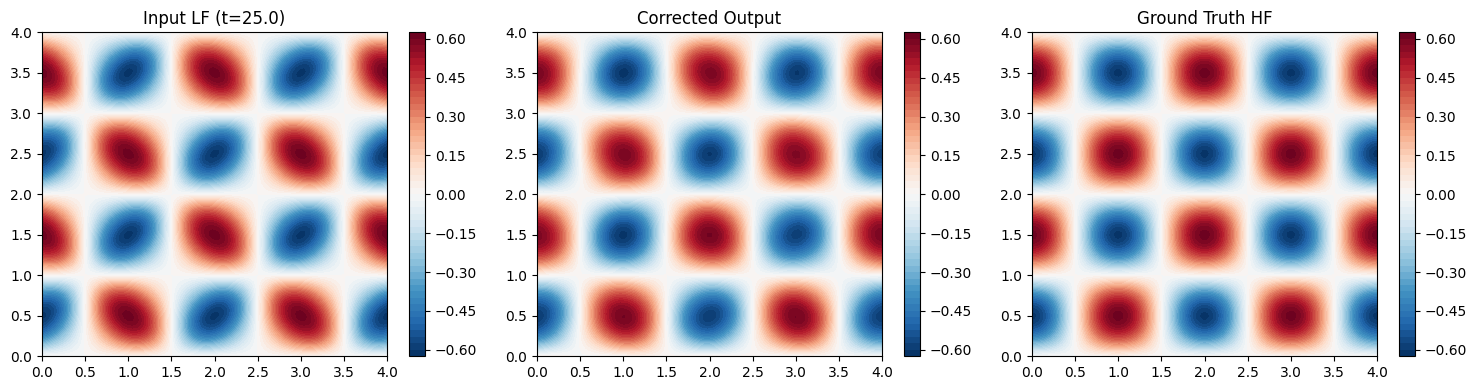


[Extrapolation (t=30.0)] Time t=30.0
Input MSE (LF vs HF): 0.00074964
Output MSE (Pred vs HF): 0.00018144
Improvement: 75.80%


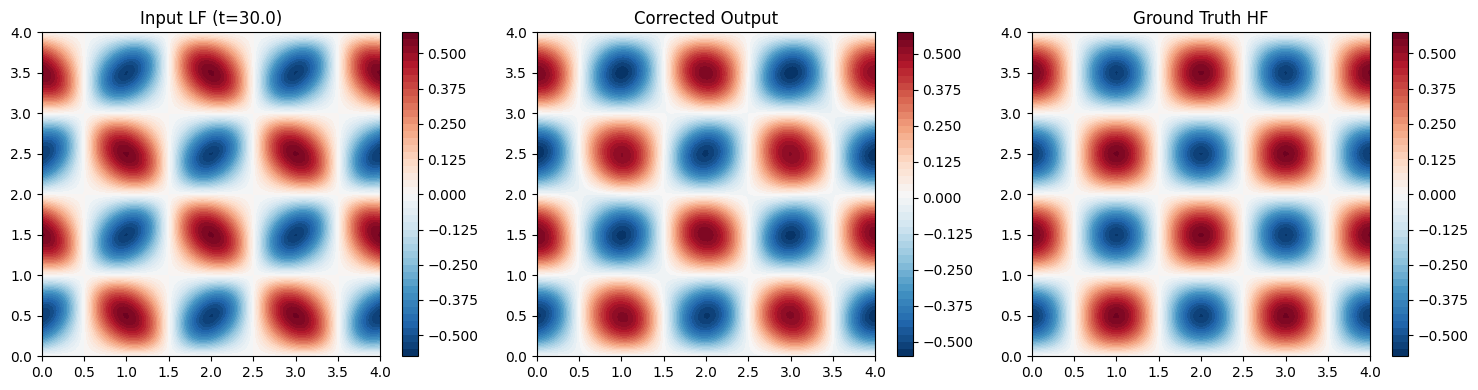

In [ ]:
test_correction(1.25, "Interpolation (t=1.25)")
test_correction(2.5, "Extrapolation (t=2.5)")
test_correction(7.3, "Extrapolation (t=7.3)")
test_correction(9.5, "Extrapolation (t=9.5)")
test_correction(11.5, "Extrapolation (t=11.5)")
test_correction(13.0, "Extrapolation (t=13.0)")
test_correction(15.0, "Extrapolation (t=15.0)")
test_correction(20.0, "Extrapolation (t=20.0)")
test_correction(25.0, "Extrapolation (t=25.0)")
test_correction(30.0, "Extrapolation (t=30.0)")

In [ ]:
import os

# 1. 저장할 폴더 생성 (없으면 생성)
save_dir = "results"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Directory '{save_dir}' created.")

# 2. 이미지를 저장하는 함수 정의
def save_visualization(test_t, scenario_name):
    # 데이터 생성
    X_g, Y_g, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, test_t)

    # 텐서 변환
    x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
    y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
    t_in = torch.tensor(np.full(x_in.shape, test_t/T_scale), dtype=torch.float32).view(-1, 1).to(device)

    u_lf_in = torch.tensor(u_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    v_lf_in = torch.tensor(v_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    p_lf_in = torch.tensor(p_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)

    # 모델 예측
    model.eval()
    with torch.no_grad():
        out = model(x_in, y_in, t_in, u_lf_in, v_lf_in, p_lf_in)
        u_pred = out[:, 0].cpu().numpy().reshape(GRID, GRID)

    # 오차 계산
    mse_lf = np.mean((u_l - u_h)**2)
    mse_pinn = np.mean((u_pred - u_h)**2)
    improvement = "N/A"
    if mse_lf > 1e-12:
        improvement = f"{(mse_lf - mse_pinn)/mse_lf * 100:.2f}%"

    # 시각화 (이미지 생성)
    plt.figure(figsize=(15, 4))

    # Input LF
    plt.subplot(1, 3, 1)
    plt.title(f"Input LF (t={test_t})")
    plt.contourf(X_g, Y_g, u_l, 50, cmap='RdBu_r')
    plt.colorbar()

    # Corrected Output
    plt.subplot(1, 3, 2)
    plt.title(f"Model Prediction\n(Improvement: {improvement})")
    plt.contourf(X_g, Y_g, u_pred, 50, cmap='RdBu_r')
    plt.colorbar()

    # Ground Truth HF
    plt.subplot(1, 3, 3)
    plt.title("Ground Truth HF")
    plt.contourf(X_g, Y_g, u_h, 50, cmap='RdBu_r')
    plt.colorbar()

    plt.tight_layout()

    # 파일 저장
    filename = f"result_t_{test_t:.2f}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=150) # 해상도 150 dpi로 저장
    plt.close() # 메모리 해제를 위해 닫기

    print(f"Saved: {filepath} | {scenario_name}")

# 3. 저장할 시간대 리스트 정의 및 실행
test_times = [
    (1.25, "Interpolation"),
    (2.5, "Interpolation"),
    (7.3, "Interpolation"),
    (9.5, "Interpolation"),
    (11.5, "Extrapolation"),
    (13.0, "Extrapolation"),
    (15.0, "Extrapolation"),
    (20.0, "Extrapolation"),
    (25.0, "Extrapolation"),
    (30.0, "Extrapolation")
]

print("--- Saving Prediction Images ---")
for t_val, desc in test_times:
    save_visualization(t_val, desc)

print("\nDone! Images are saved in the 'results' folder.")

# 4. (선택사항) 폴더를 압축해서 다운로드 받기 쉽게 만들기
import shutil
shutil.make_archive('results_archive', 'zip', save_dir)
print("Zip file created: results_archive.zip")

--- Saving Prediction Images ---
Saved: results/result_t_1.25.png | Interpolation
Saved: results/result_t_2.50.png | Interpolation
Saved: results/result_t_7.30.png | Interpolation
Saved: results/result_t_9.50.png | Interpolation
Saved: results/result_t_11.50.png | Extrapolation
Saved: results/result_t_13.00.png | Extrapolation
Saved: results/result_t_15.00.png | Extrapolation
Saved: results/result_t_20.00.png | Extrapolation
Saved: results/result_t_25.00.png | Extrapolation
Saved: results/result_t_30.00.png | Extrapolation

Done! Images are saved in the 'results' folder.
Zip file created: results_archive.zip


Generating and saving separate graphs...
Graph 1 Saved: results/mse_comparison.png


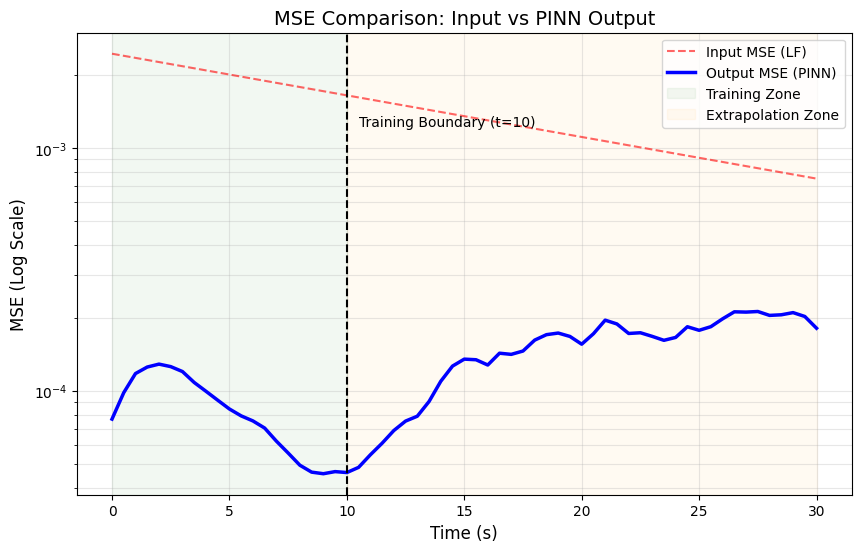

Graph 2 Saved: results/improvement_rate.png


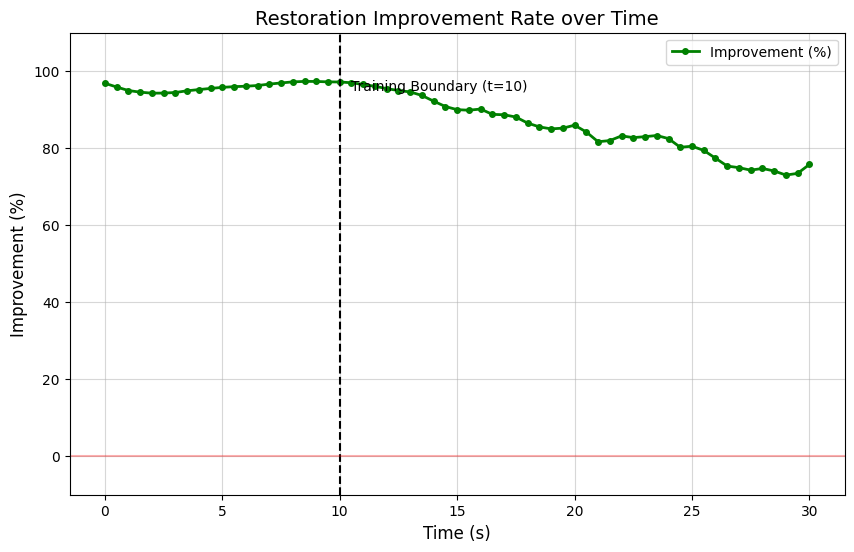

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os

# 저장 경로 설정
save_dir = "results"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def save_separate_graphs():
    print("Generating and saving separate graphs...")

    # 1. 데이터 계산 (기존과 동일)
    t_eval = np.linspace(0, 30, 61)
    mse_lf_list = []
    mse_pinn_list = []
    improvement_list = []

    model.eval()
    with torch.no_grad():
        for t_val in t_eval:
            X_g, Y_g, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, t_val)

            x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
            y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
            t_in = torch.tensor(np.full(x_in.shape, t_val/T_scale), dtype=torch.float32).view(-1, 1).to(device)

            u_lf_in = torch.tensor(u_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
            v_lf_in = torch.tensor(v_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
            p_lf_in = torch.tensor(p_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)

            out = model(x_in, y_in, t_in, u_lf_in, v_lf_in, p_lf_in)
            u_pred = out[:, 0].cpu().numpy().reshape(GRID, GRID)

            mse_lf = np.mean((u_l - u_h)**2)
            mse_pinn = np.mean((u_pred - u_h)**2)

            if mse_lf > 1e-15:
                imp = (mse_lf - mse_pinn) / mse_lf * 100
            else:
                imp = 0.0

            mse_lf_list.append(mse_lf)
            mse_pinn_list.append(mse_pinn)
            improvement_list.append(imp)

    # -------------------------------------------------------
    # [그래프 1] MSE Comparison (Log Scale)
    # -------------------------------------------------------
    plt.figure(figsize=(10, 6))

    plt.plot(t_eval, mse_lf_list, 'r--', label='Input MSE (LF)', alpha=0.6)
    plt.plot(t_eval, mse_pinn_list, 'b-', label='Output MSE (PINN)', linewidth=2.5)

    # 영역 표시 및 장식
    plt.axvline(x=10, color='k', linestyle='--', linewidth=1.5)
    plt.text(10.5, max(mse_lf_list)*0.5, 'Training Boundary (t=10)', fontsize=10)
    plt.axvspan(0, 10, color='green', alpha=0.05, label='Training Zone')
    plt.axvspan(10, 30, color='orange', alpha=0.05, label='Extrapolation Zone')

    plt.yscale('log') # 로그 스케일
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('MSE (Log Scale)', fontsize=12)
    plt.title('MSE Comparison: Input vs PINN Output', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, which="both", ls="-", alpha=0.3)

    # 저장
    save_path_mse = os.path.join(save_dir, "mse_comparison.png")
    plt.savefig(save_path_mse, dpi=300) # 고해상도 저장
    print(f"Graph 1 Saved: {save_path_mse}")
    plt.show()

    # -------------------------------------------------------
    # [그래프 2] Restoration Improvement Rate
    # -------------------------------------------------------
    plt.figure(figsize=(10, 6))

    plt.plot(t_eval, improvement_list, 'g.-', label='Improvement (%)', linewidth=2, markersize=8)

    # 영역 표시 및 장식
    plt.axvline(x=10, color='k', linestyle='--', linewidth=1.5)
    plt.text(10.5, 95, 'Training Boundary (t=10)', fontsize=10)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3) # 0% 기준선

    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Improvement (%)', fontsize=12)
    plt.title('Restoration Improvement Rate over Time', fontsize=14)
    plt.ylim(-10, 110)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.5)

    # 저장
    save_path_imp = os.path.join(save_dir, "improvement_rate.png")
    plt.savefig(save_path_imp, dpi=300) # 고해상도 저장
    print(f"Graph 2 Saved: {save_path_imp}")
    plt.show()

# 실행
save_separate_graphs()

Generating and saving separate graphs (Detailed Y-axis)...
Graph 1 Saved: results/mse_comparison.png


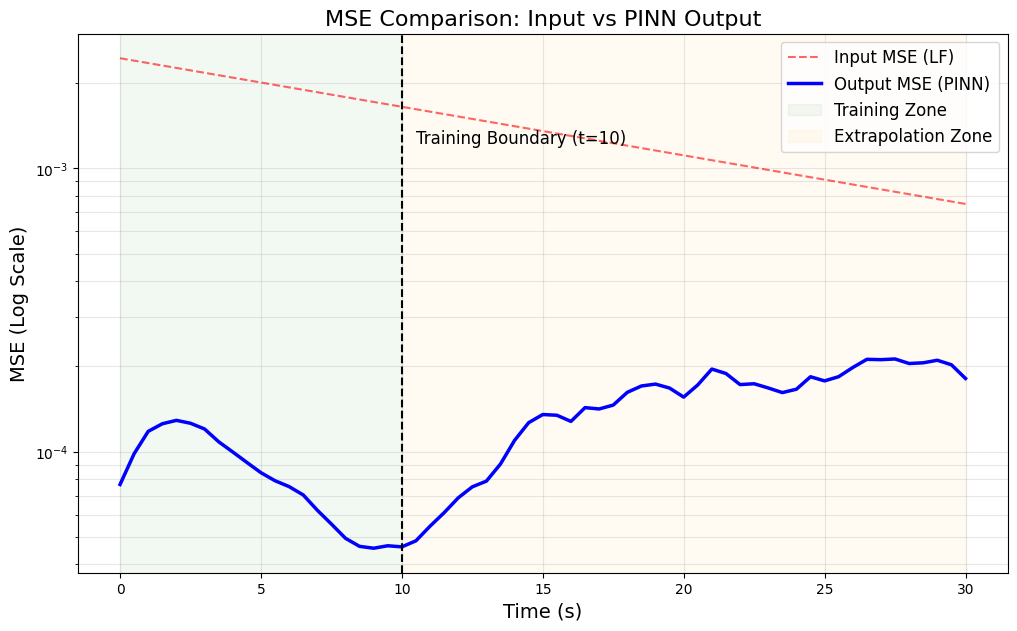

Graph 2 Saved: results/improvement_rate_detail.png


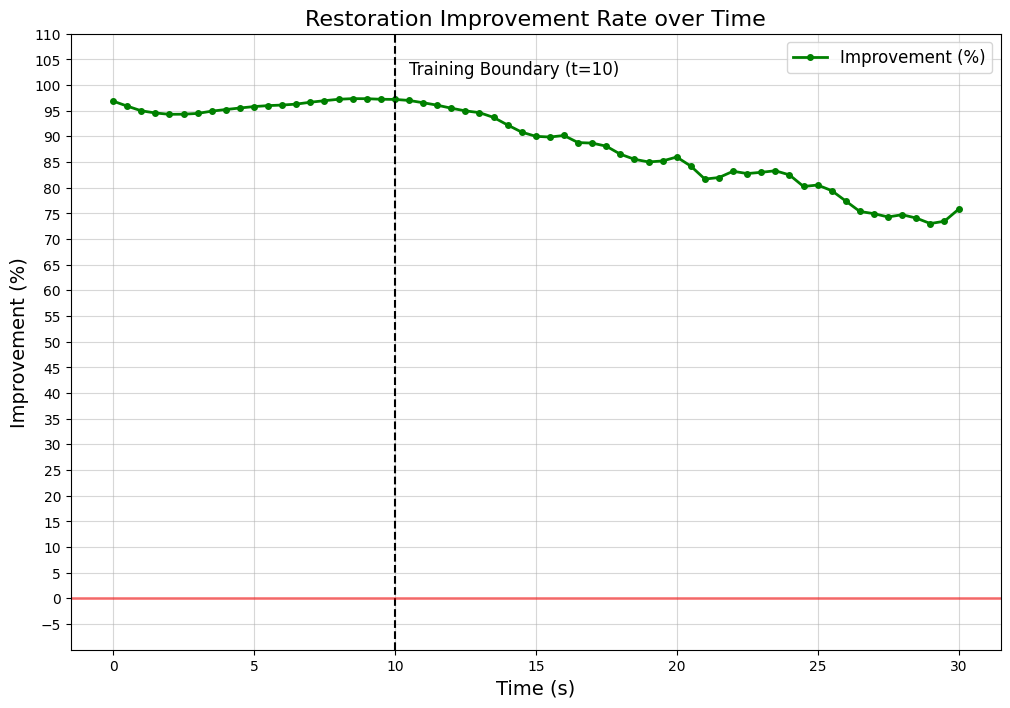

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os

# 저장 경로 설정
save_dir = "results"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def save_separate_graphs_detailed():
    print("Generating and saving separate graphs (Detailed Y-axis)...")

    # 1. 데이터 계산 (기존과 동일)
    t_eval = np.linspace(0, 30, 61)
    mse_lf_list = []
    mse_pinn_list = []
    improvement_list = []

    model.eval()
    with torch.no_grad():
        for t_val in t_eval:
            X_g, Y_g, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, t_val)

            x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
            y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
            t_in = torch.tensor(np.full(x_in.shape, t_val/T_scale), dtype=torch.float32).view(-1, 1).to(device)

            u_lf_in = torch.tensor(u_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
            v_lf_in = torch.tensor(v_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
            p_lf_in = torch.tensor(p_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)

            out = model(x_in, y_in, t_in, u_lf_in, v_lf_in, p_lf_in)
            u_pred = out[:, 0].cpu().numpy().reshape(GRID, GRID)

            mse_lf = np.mean((u_l - u_h)**2)
            mse_pinn = np.mean((u_pred - u_h)**2)

            if mse_lf > 1e-15:
                imp = (mse_lf - mse_pinn) / mse_lf * 100
            else:
                imp = 0.0

            mse_lf_list.append(mse_lf)
            mse_pinn_list.append(mse_pinn)
            improvement_list.append(imp)

    # -------------------------------------------------------
    # [그래프 1] MSE Comparison (Log Scale)
    # -------------------------------------------------------
    plt.figure(figsize=(12, 7)) # 크기 살짝 키움

    plt.plot(t_eval, mse_lf_list, 'r--', label='Input MSE (LF)', alpha=0.6)
    plt.plot(t_eval, mse_pinn_list, 'b-', label='Output MSE (PINN)', linewidth=2.5)

    plt.axvline(x=10, color='k', linestyle='--', linewidth=1.5)
    plt.text(10.5, max(mse_lf_list)*0.5, 'Training Boundary (t=10)', fontsize=12)
    plt.axvspan(0, 10, color='green', alpha=0.05, label='Training Zone')
    plt.axvspan(10, 30, color='orange', alpha=0.05, label='Extrapolation Zone')

    plt.yscale('log')
    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('MSE (Log Scale)', fontsize=14)
    plt.title('MSE Comparison: Input vs PINN Output', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, which="both", ls="-", alpha=0.3)

    save_path_mse = os.path.join(save_dir, "mse_comparison.png")
    plt.savefig(save_path_mse, dpi=300)
    print(f"Graph 1 Saved: {save_path_mse}")
    plt.show()

    # -------------------------------------------------------
    # [그래프 2] Restoration Improvement Rate (Y축 5단위)
    # -------------------------------------------------------
    plt.figure(figsize=(12, 8)) # Y축이 촘촘하므로 세로 길이를 키움

    plt.plot(t_eval, improvement_list, 'g.-', label='Improvement (%)', linewidth=2, markersize=8)

    plt.axvline(x=10, color='k', linestyle='--', linewidth=1.5)
    plt.text(10.5, 102, 'Training Boundary (t=10)', fontsize=12)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.5, linewidth=2)

    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('Improvement (%)', fontsize=14)
    plt.title('Restoration Improvement Rate over Time', fontsize=16)

    # [수정된 부분] Y축 눈금 설정 (5단위)
    # np.arange(시작, 끝(포함안됨), 간격) -> -10부터 110까지 5단위
    plt.yticks(np.arange(-5, 115, 5))
    plt.ylim(-10, 110)

    plt.legend(fontsize=12)
    plt.grid(True, which='both', alpha=0.5) # 그리드 켜기

    save_path_imp = os.path.join(save_dir, "improvement_rate_detail.png")
    plt.savefig(save_path_imp, dpi=300)
    print(f"Graph 2 Saved: {save_path_imp}")
    plt.show()

# 실행
save_separate_graphs_detailed()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os

# 저장 경로
save_dir = "results"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def plot_broken_axis_improvement():
    print("Generating Broken Axis Graph...")

    # 1. 데이터 계산 (이전과 동일)
    t_eval = np.linspace(0, 30, 61)
    improvement_list = []

    model.eval()
    with torch.no_grad():
        for t_val in t_eval:
            X_g, Y_g, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, t_val)
            # ... (데이터 생성 및 예측 부분은 동일) ...
            x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
            y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
            t_in = torch.tensor(np.full(x_in.shape, t_val/T_scale), dtype=torch.float32).view(-1, 1).to(device)

            u_lf_in = torch.tensor(u_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
            v_lf_in = torch.tensor(v_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
            p_lf_in = torch.tensor(p_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)

            out = model(x_in, y_in, t_in, u_lf_in, v_lf_in, p_lf_in)
            u_pred = out[:, 0].cpu().numpy().reshape(GRID, GRID)

            mse_lf = np.mean((u_l - u_h)**2)
            mse_pinn = np.mean((u_pred - u_h)**2)

            if mse_lf > 1e-15:
                imp = (mse_lf - mse_pinn) / mse_lf * 100
            else:
                imp = 0.0
            improvement_list.append(imp)

    # 2. 그래프 설정 (위/아래 2개로 쪼개기)
    # sharex=True: X축 공유, height_ratios: 위쪽 그래프를 4배 더 크게
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8),
                                   gridspec_kw={'height_ratios': [4, 1]})

    # 3. 데이터 그리기 (두 축 모두에 똑같이 그림)
    ax1.plot(t_eval, improvement_list, 'g.-', label='Improvement (%)', linewidth=2, markersize=8)
    ax2.plot(t_eval, improvement_list, 'g.-', linewidth=2, markersize=8)

    # 4. Y축 범위 설정 (여기가 핵심!)
    # ax1 (위쪽): 데이터가 있는 65 ~ 105 구간 확대
    ax1.set_ylim(65, 105)
    ax1.set_yticks(np.arange(65, 106, 5)) # 5단위 눈금

    # ax2 (아래쪽): 0% 기준선 근처 (-2 ~ 2)
    ax2.set_ylim(-2, 2)
    ax2.set_yticks([0]) # 0만 표시

    # 5. 장식 요소 추가
    # 기준선 (아래쪽 그래프에만)
    ax2.axhline(y=0, color='r', linestyle='-', alpha=0.5, linewidth=2)

    # 학습 경계선 (위쪽 그래프에만)
    ax1.axvline(x=10, color='k', linestyle='--', linewidth=1.5)
    ax1.text(10.5, 100, 'Training Boundary (t=10)', fontsize=12)

    # 그리드
    ax1.grid(True, which='both', alpha=0.5)
    ax2.grid(True, which='both', alpha=0.5)

    # 6. 중간 잘린 부분 처리 (Broken Axis 효과)
    ax1.spines['bottom'].set_visible(False) # 위쪽 그래프 아랫변 제거
    ax2.spines['top'].set_visible(False)    # 아래쪽 그래프 윗변 제거
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)  # 위쪽 그래프 X축 라벨 숨김
    ax2.xaxis.tick_bottom()

    # 사선(//) 그리기 (잘린 느낌)
    d = .015  # 사선 크기
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)        # Top-left diagonal
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # 아래쪽 그래프 좌표계로 변경
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Bottom-right diagonal

    # 7. 라벨 및 저장
    ax1.set_title('Restoration Improvement Rate over Time (Broken Axis)', fontsize=16)
    ax2.set_xlabel('Time (s)', fontsize=14)
    # Y축 라벨은 가운데 쯤에 하나로 표시하기 위해 fig.text 사용
    fig.text(0.04, 0.5, 'Improvement (%)', va='center', rotation='vertical', fontsize=14)

    ax1.legend(loc='upper right', fontsize=12)

    plt.tight_layout()
    # 그래프 간격 조절 (h_pad를 줄여서 붙어 보이게 함)
    plt.subplots_adjust(hspace=0.05)

    save_path = os.path.join(save_dir, "improvement_rate_broken_axis.png")
    plt.savefig(save_path, dpi=300)
    print(f"Graph Saved: {save_path}")
    plt.show()

plot_broken_axis_improvement()

Generating Broken Axis Graph...


NameError: name 'model' is not defined